# Distributions of all the events in the dataset

In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append('/home/fcufino/ETH_faser/Utils')

from Utils.plot import *
from Utils.event_filter import *
from Utils.ID_events import *

In [20]:
folder_path = "/scratch3/salonso/faser/events_v3.5"  
output_folder = "/scratch/fcufino"

os.makedirs(output_folder, exist_ok=True)

In [21]:
variables_to_extract = ['e_vis', 'sp_momentum', 'vis_sp_momentum', 'jet_momentum', 'pt_miss',
                        'in_neutrino_momentum', 'in_neutrino_energy',
                        'out_lepton_momentum', 'out_lepton_energy',
                        'rear_cal_energy', 'rear_hcal_energy', 'rear_mucal_energy','faser_cal_energy', 'reco_hits']

In [ ]:
id_features = ["run_number", "event_id", "is_cc", "in_neutrino_pdg"]
data_filter = load_variables_from_npz(folder_path, id_features)

The dataset is loaded twice. Initially, only the smallest set of features that are needed to ID the files and mask the relevant data. In this case, for the plot of the distributions all files are being loaded, but in the future,  if there is a need to load only specific features (e.g., only nu_e), this approach allows for that without loading all the features from all files.


In [ ]:
dict_nu_e   = create_masked_dict(data_filter, is_cc=1, is_nu_e=1, is_nu_mu=0, is_nu_tau=0)
dict_nu_mu  = create_masked_dict(data_filter, is_cc=1, is_nu_e=0, is_nu_mu=1, is_nu_tau=0)
dict_nu_tau = create_masked_dict(data_filter, is_cc=1, is_nu_e=0, is_nu_mu=0, is_nu_tau=1)
dict_nc     = create_masked_dict(data_filter, is_cc=0, is_nu_e=0, is_nu_mu=0, is_nu_tau=0)

# Print the number of events in each dictionary
print("Number of events in the dictionary: ", len(data_filter["run_number"]))
print("--------------------------------------")
print("Number of events in the nu_e dictionary: ", len(dict_nu_e["run_number"]))
print("Number of events in the nu_mu dictionary: ", len(dict_nu_mu["run_number"]))
print("Number of events in the nu_tau dictionary: ", len(dict_nu_tau["run_number"]))
print("Number of events in the NC dictionary: ", len(dict_nc["run_number"]))

Number of events in the dictionary:  144939
--------------------------------------
Number of events in the nu_e dictionary:  18218
Number of events in the nu_mu dictionary:  89087
Number of events in the nu_tau dictionary:  473
Number of events in the NC dictionary:  37161


In [ ]:
file_names_nc = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nc["run_number"], dict_nc["event_id"])]
file_names_nu_e = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_e["run_number"], dict_nu_e["event_id"])]
file_names_nu_mu = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_mu["run_number"], dict_nu_mu["event_id"])]
file_names_nu_tau = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_tau["run_number"], dict_nu_tau["event_id"])]

In [ ]:
data_nc = np.load(f"{output_folder}/data_nc.npz", allow_pickle=True)
data_nu_e = np.load(f"{output_folder}/data_nu_e.npz", allow_pickle=True)
data_nu_mu = np.load(f"{output_folder}/data_nu_mu.npz", allow_pickle=True)
data_nu_tau = np.load(f"{output_folder}/data_nu_tau.npz", allow_pickle=True)

In [ ]:
#if the files exist load the data otherwise create the files
if os.path.exists(f"{output_folder}/data_nc.npz") and os.path.exists(f"{output_folder}/data_nu_e.npz") and os.path.exists(f"{output_folder}/data_nu_mu.npz") and os.path.exists(f"{output_folder}/data_nu_tau.npz"):
    print("Data already saved in .npz files, load them.")
    data_nc = np.load(f"{output_folder}/data_nc.npz", allow_pickle=True)
    data_nu_e = np.load(f"{output_folder}/data_nu_e.npz", allow_pickle=True)
    data_nu_mu = np.load(f"{output_folder}/data_nu_mu.npz", allow_pickle=True)
    data_nu_tau = np.load(f"{output_folder}/data_nu_tau.npz", allow_pickle=True)
    print("Data loaded from .npz files")

else:
    print
    data_nc     = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nc)
    data_nu_e   = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_e)
    data_nu_mu  = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_mu)
    data_nu_tau = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_tau)

    np.savez(f"{output_folder}/data_nc.npz", **data_nc)
    np.savez(f"{output_folder}/data_nu_e.npz", **data_nu_e)
    np.savez(f"{output_folder}/data_nu_mu.npz", **data_nu_mu)
    np.savez(f"{output_folder}/data_nu_tau.npz", **data_nu_tau)

    print("Data saved in .npz files")

Data already saved in .npz files, load them.
Data loaded from .npz files


## Distribution Plot

In [ ]:
configure_matplotlib()

In [ ]:
def plot_histograms(data_nu_e, data_nu_mu, data_nu_tau, data_nc, variable_name, bins=20, figsize=(20, 5)):
    """
    Plots histograms for each component (column) of the specified 2D variable across different datasets.
    """
    # RGB color for purple normalized to [0, 1] range
    purple_color = (190/255, 130/255, 211/255)

    # Function to stack all hits into a single 2D array
    def extract_hits(data, variable_name):
        return np.vstack(data[variable_name])  # Shape (Total_hits, Num_columns)

    # Extract stacked data
    data_e = extract_hits(data_nu_e, variable_name)
    data_mu = extract_hits(data_nu_mu, variable_name)
    data_tau = extract_hits(data_nu_tau, variable_name)
    data_nc = extract_hits(data_nc, variable_name)

    num_columns = data_e.shape[1]  # Number of features in reco_hits

    for i in range(num_columns):
        fig, axes = plt.subplots(1, 4, figsize=figsize)

        # Plot the histograms in the respective subplots
        axes[0].hist(data_e[:, i], bins=bins, alpha=0.7, color=purple_color, edgecolor='black')
        axes[0].set_title(f'nu_e')
        axes[0].set_xlabel(f'{variable_name}_{i}')
        axes[0].set_ylabel('Frequency')

        axes[1].hist(data_mu[:, i], bins=bins, alpha=0.7, color=purple_color, edgecolor='black')
        axes[1].set_title(f'nu_mu')
        axes[1].set_xlabel(f'{variable_name}_{i}')
        axes[1].set_ylabel('Frequency')

        axes[2].hist(data_tau[:, i], bins=bins, alpha=0.7, color=purple_color, edgecolor='black')
        axes[2].set_title(f'nu_tau')
        axes[2].set_xlabel(f'{variable_name}_{i}')
        axes[2].set_ylabel('Frequency')

        axes[3].hist(data_nc[:, i], bins=bins, alpha=0.7, color=purple_color, edgecolor='black')
        axes[3].set_title(f'NC')
        axes[3].set_xlabel(f'{variable_name}_{i}')
        axes[3].set_ylabel('Frequency')

        # Adjust layout and show
        plt.tight_layout()
        plt.show()


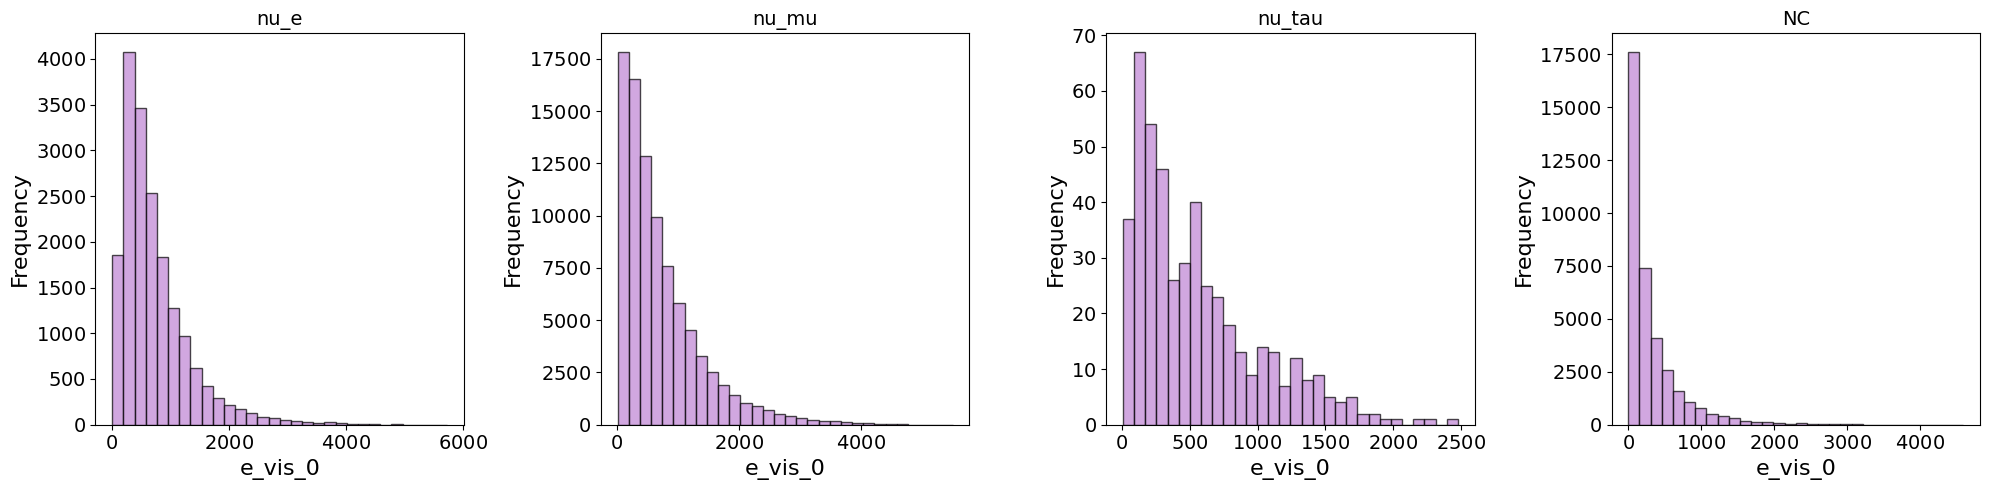

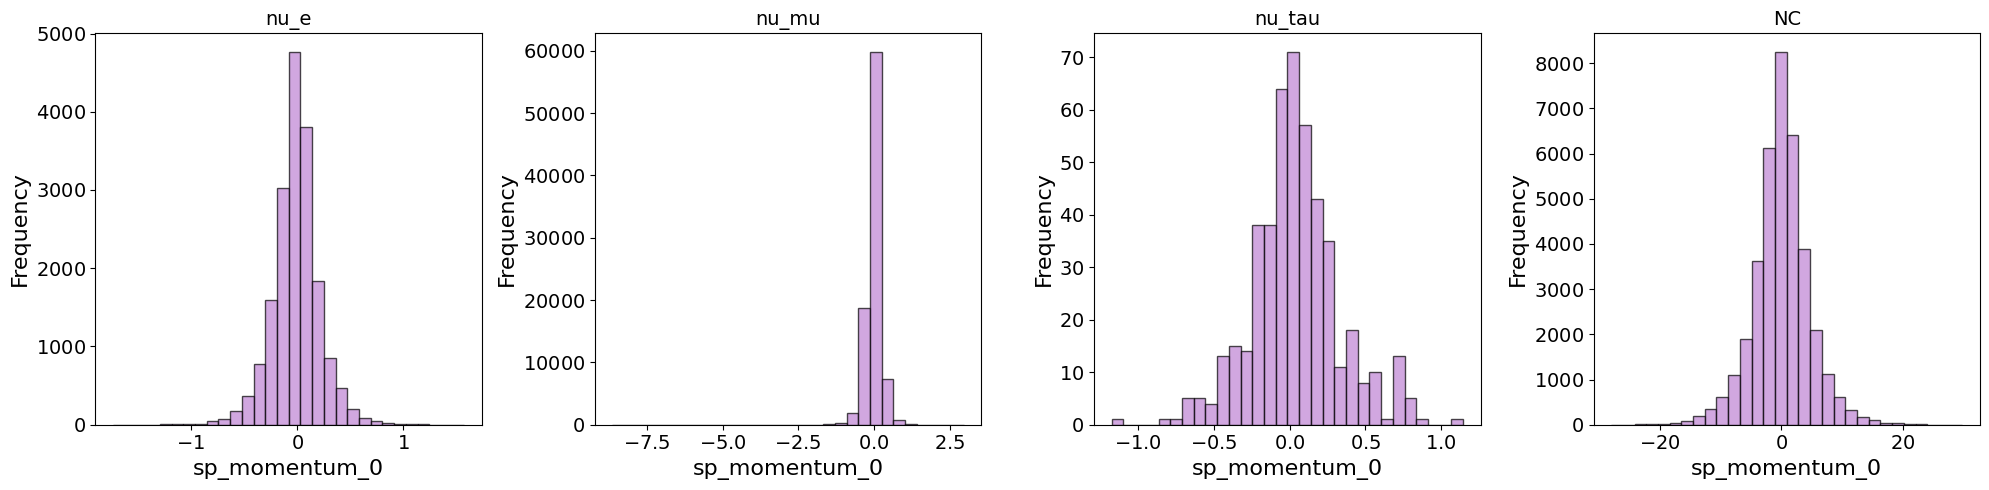

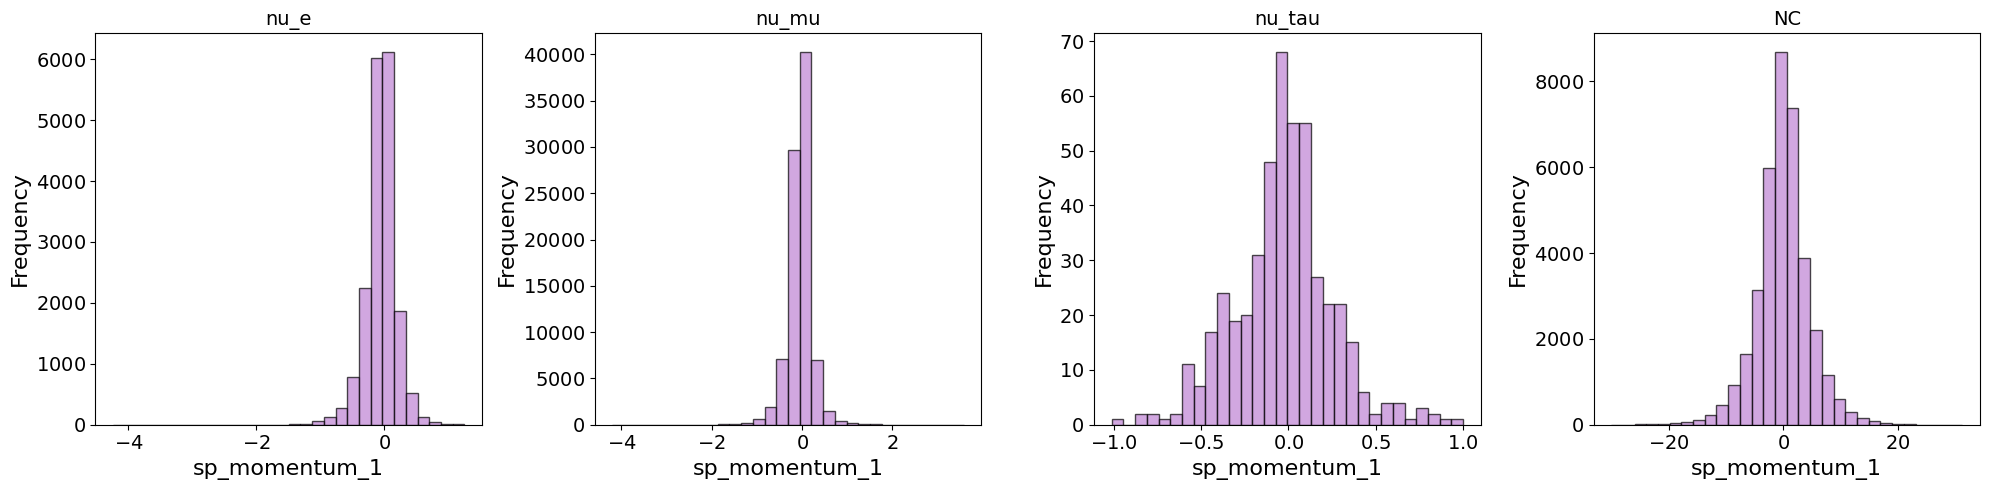

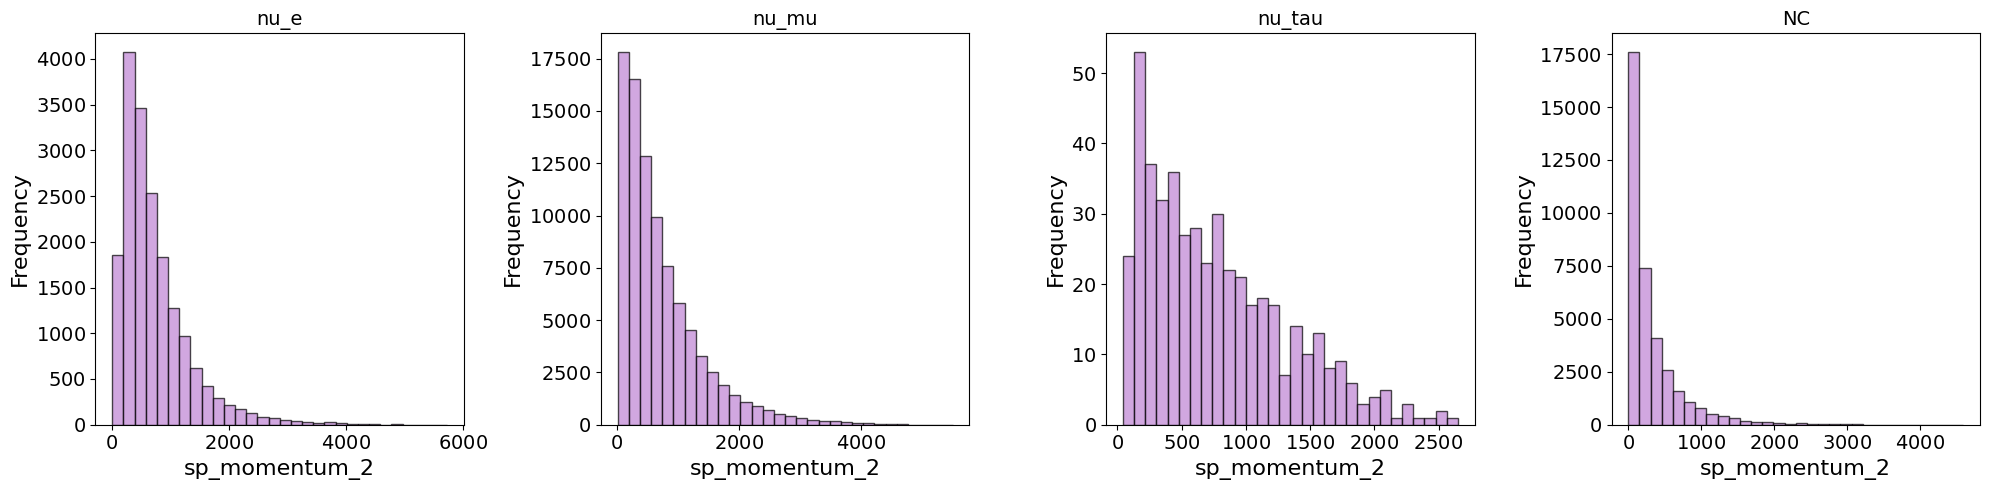

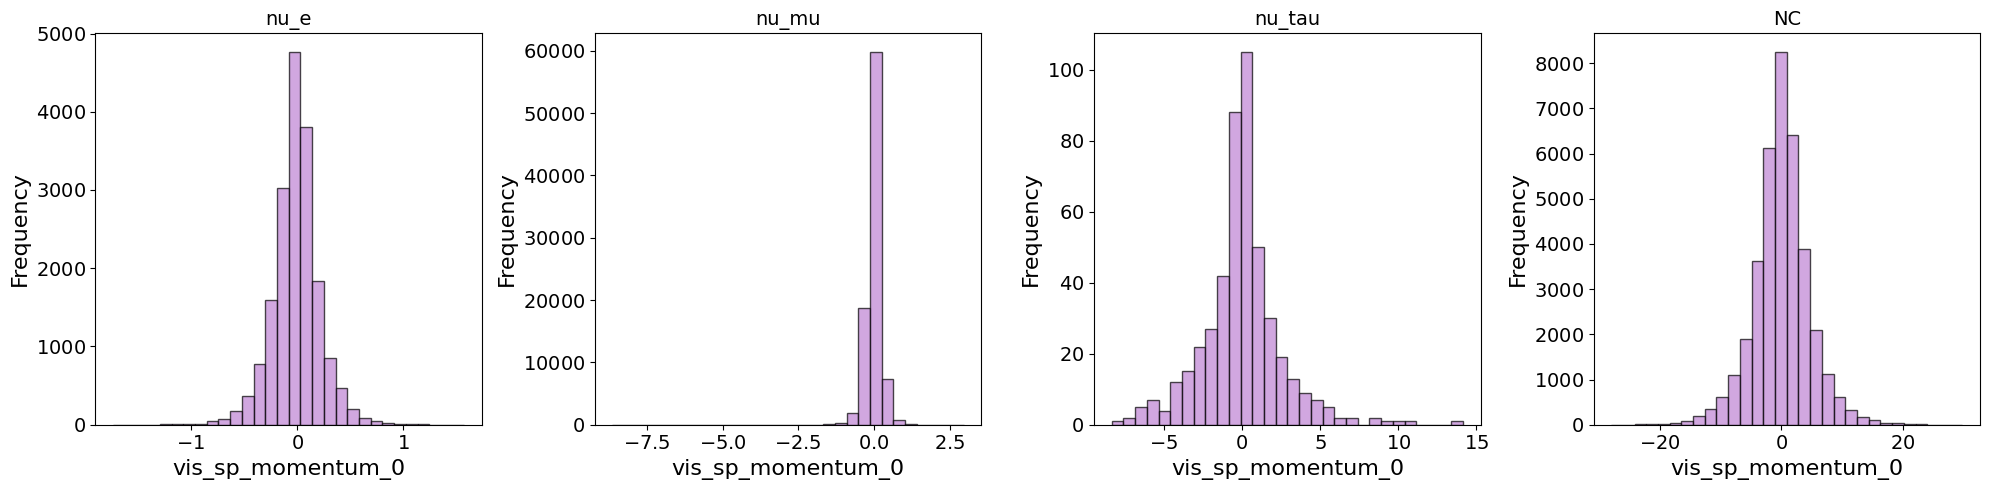

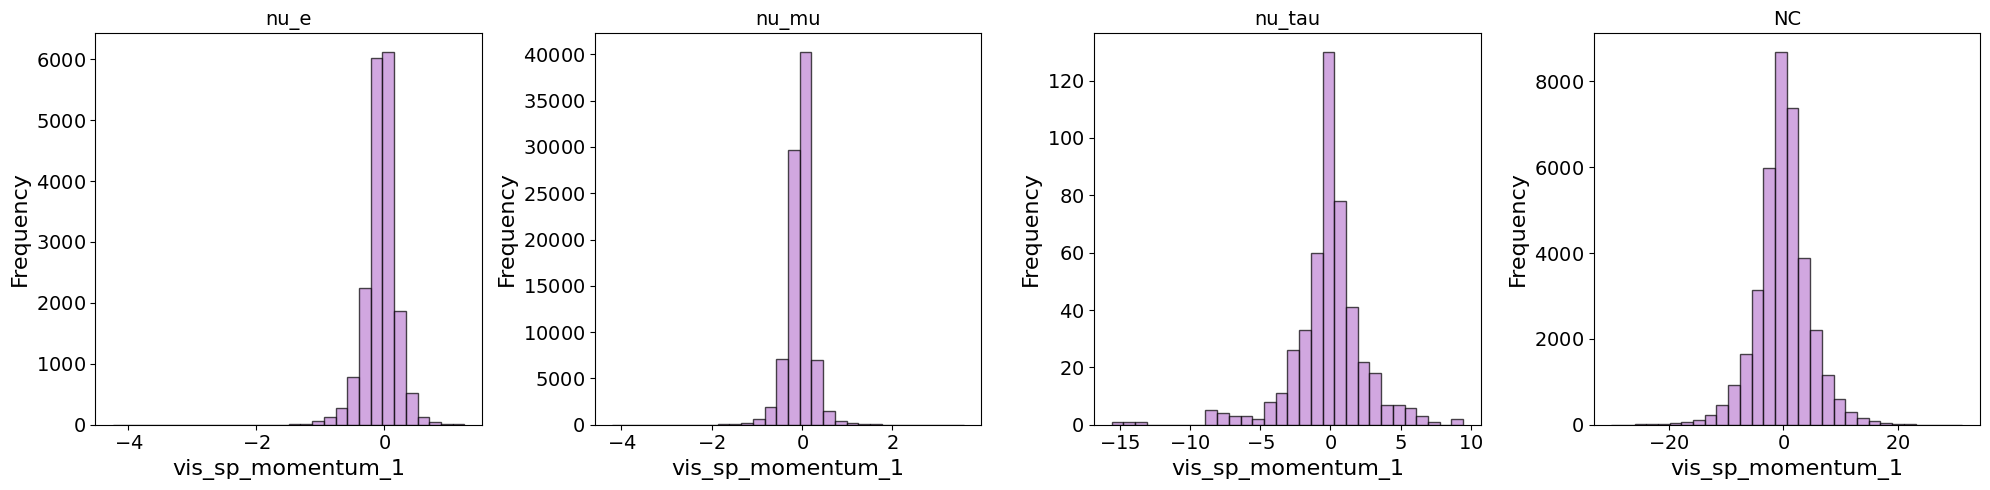

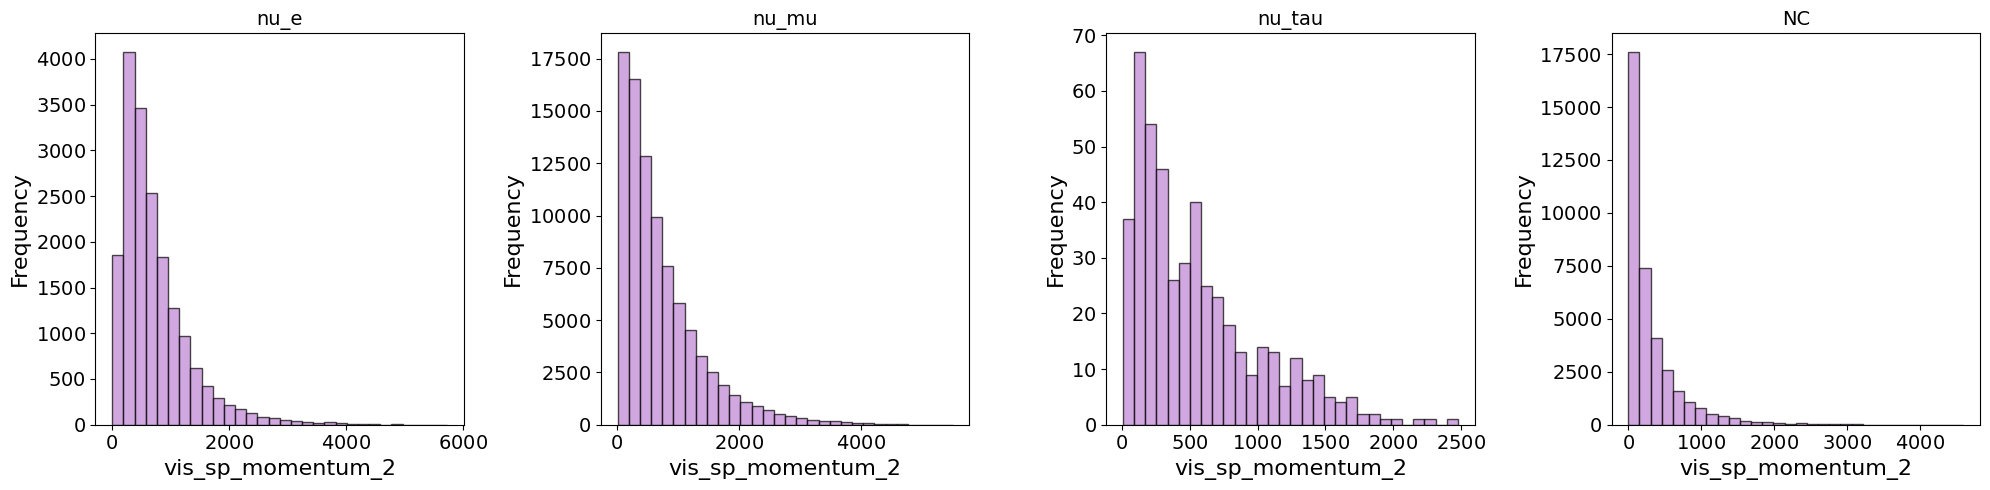

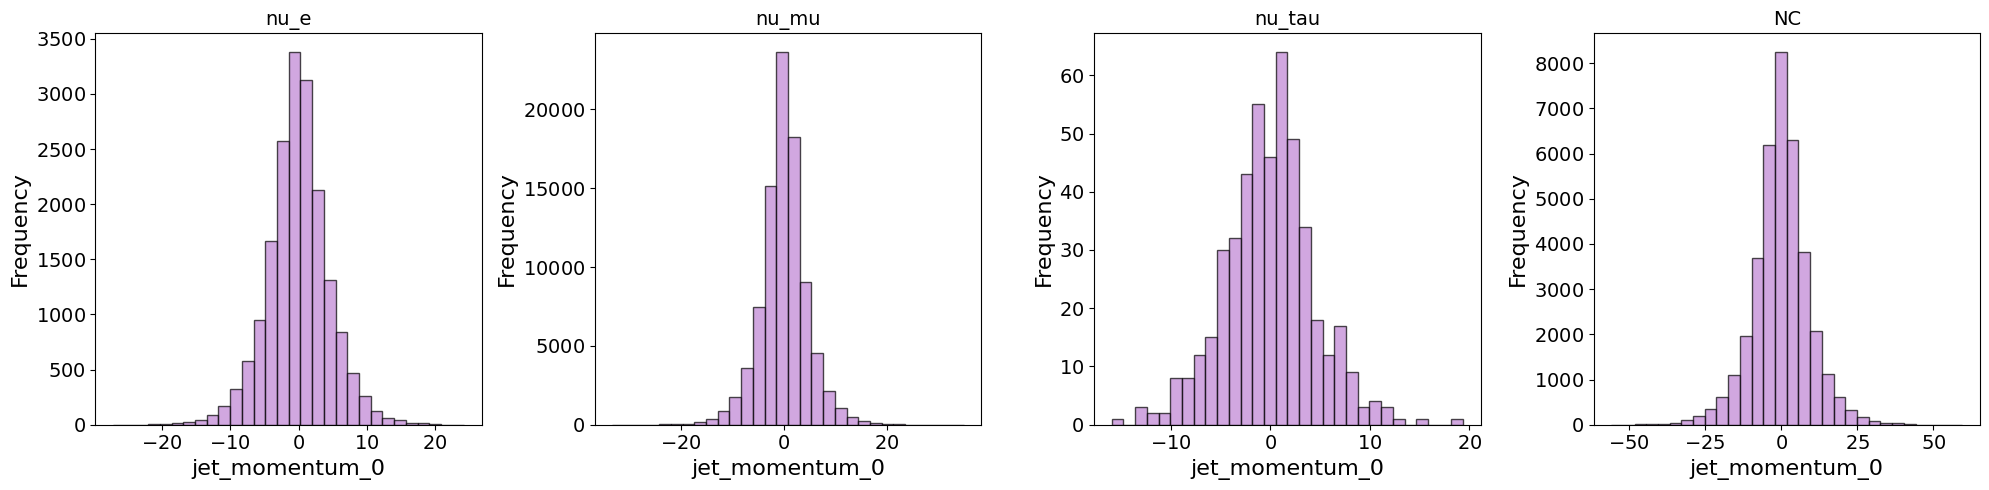

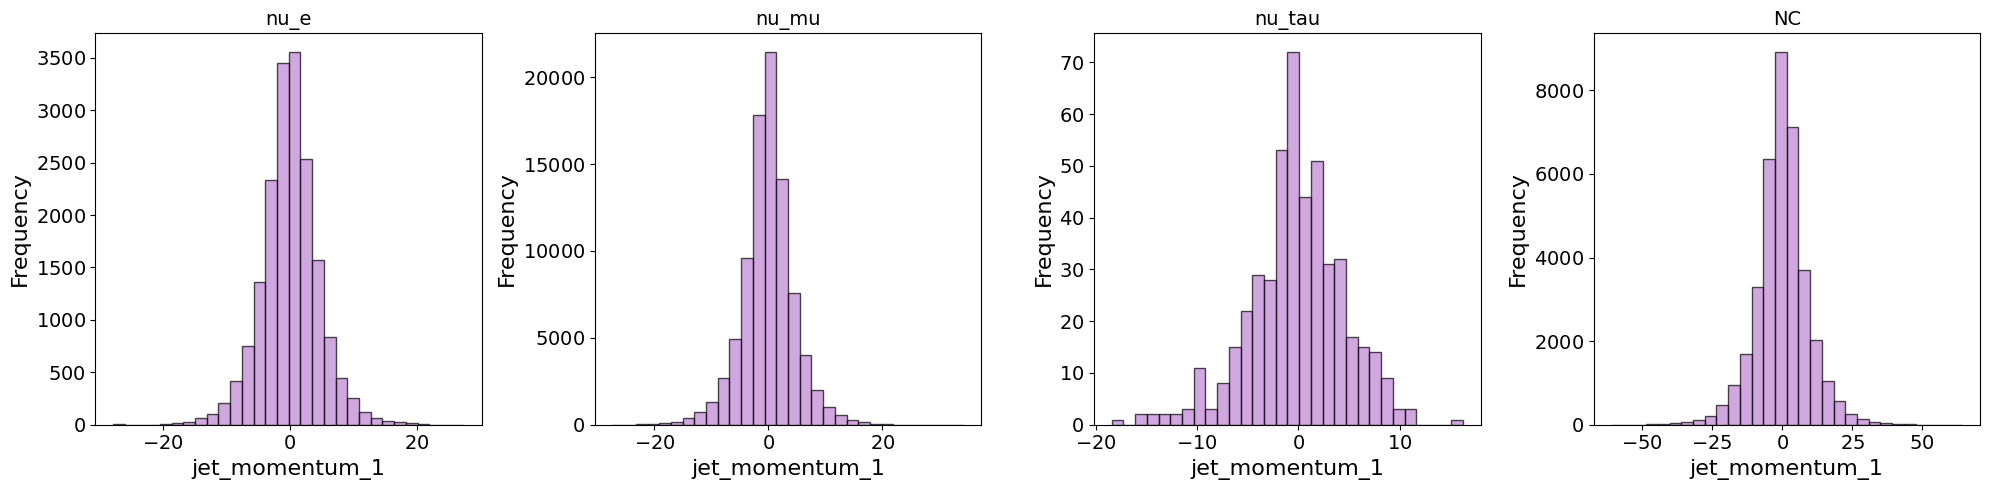

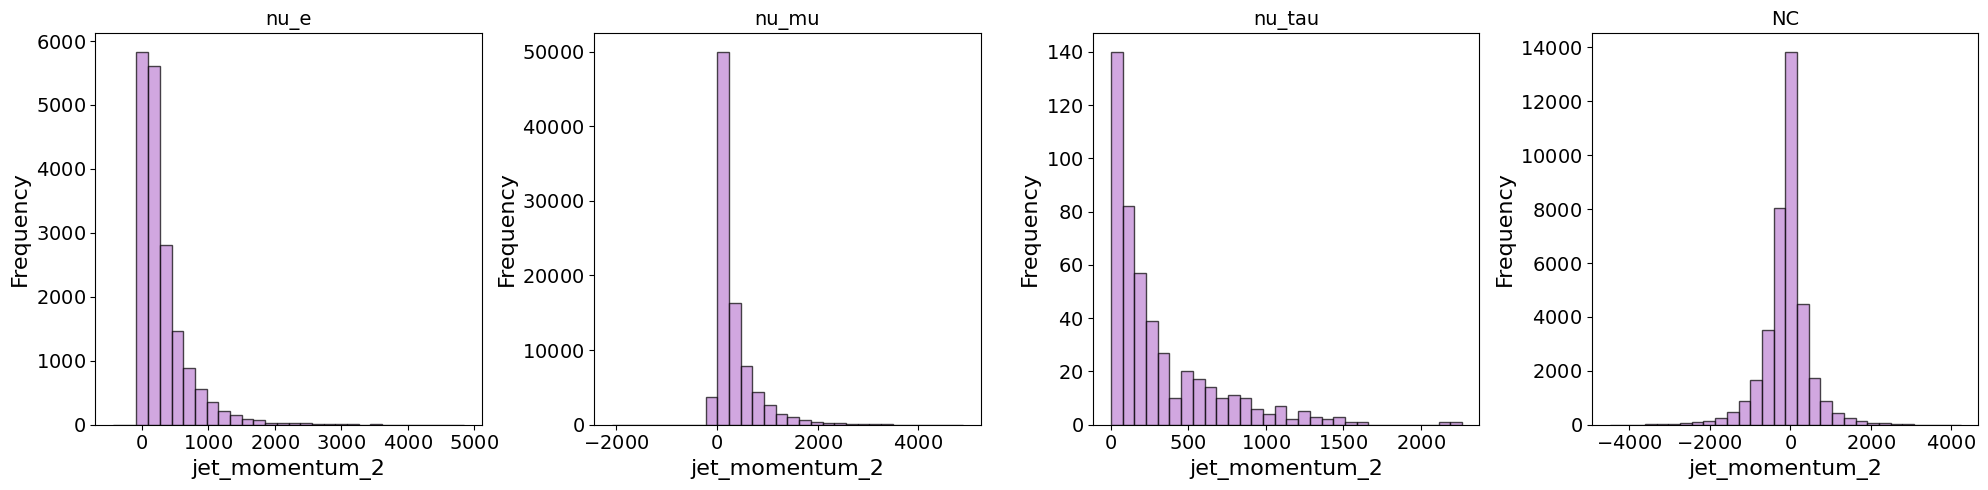

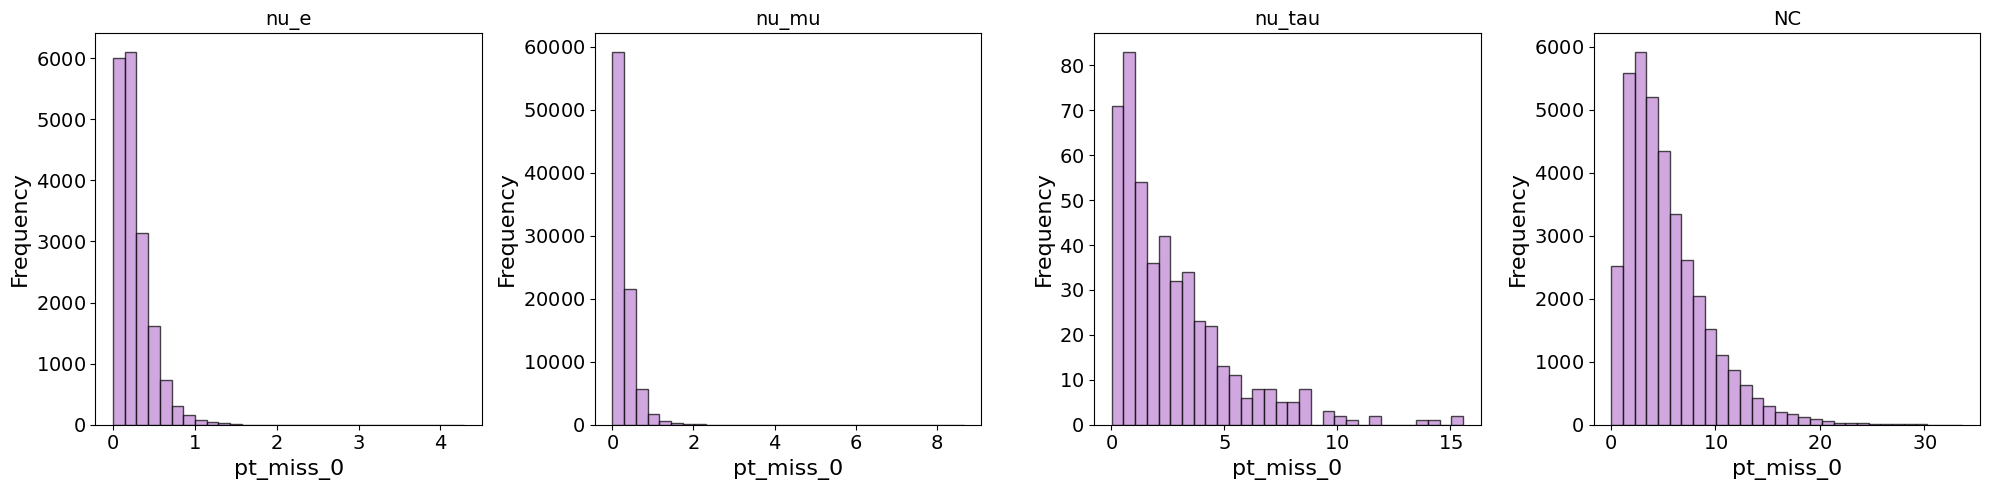

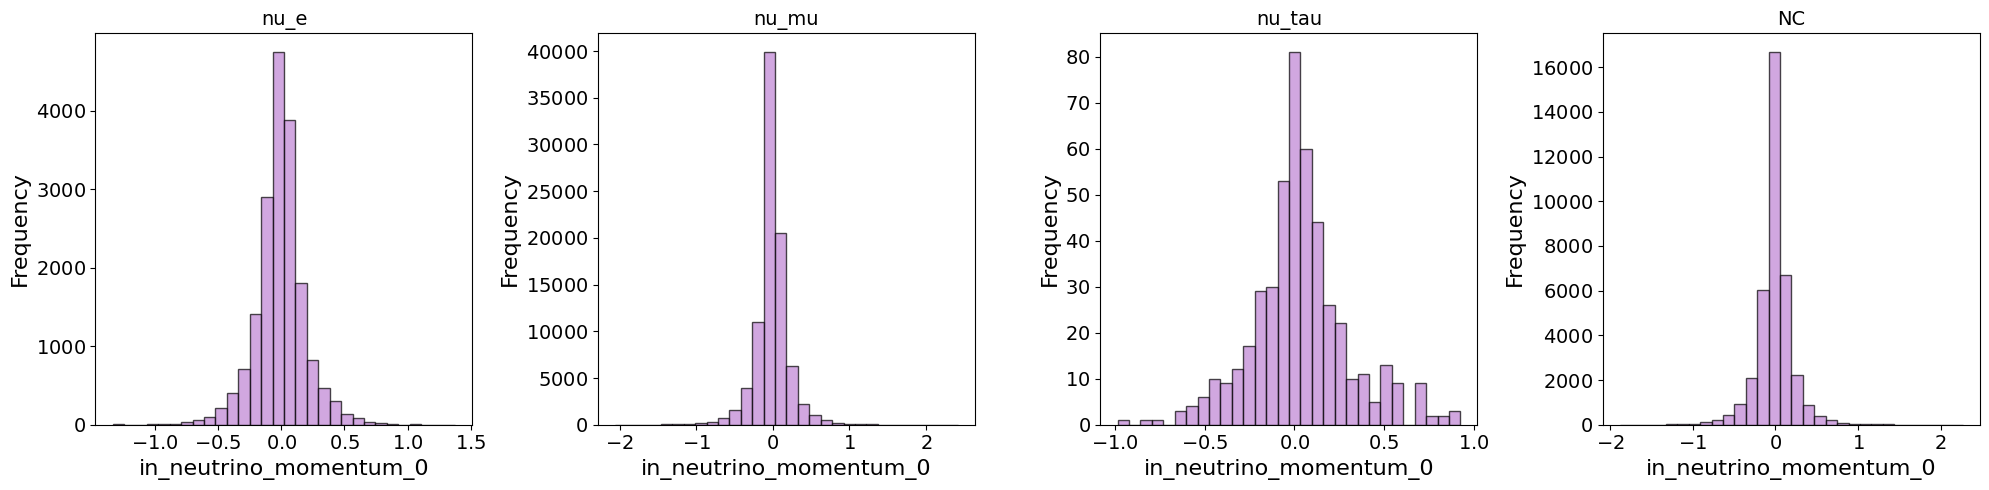

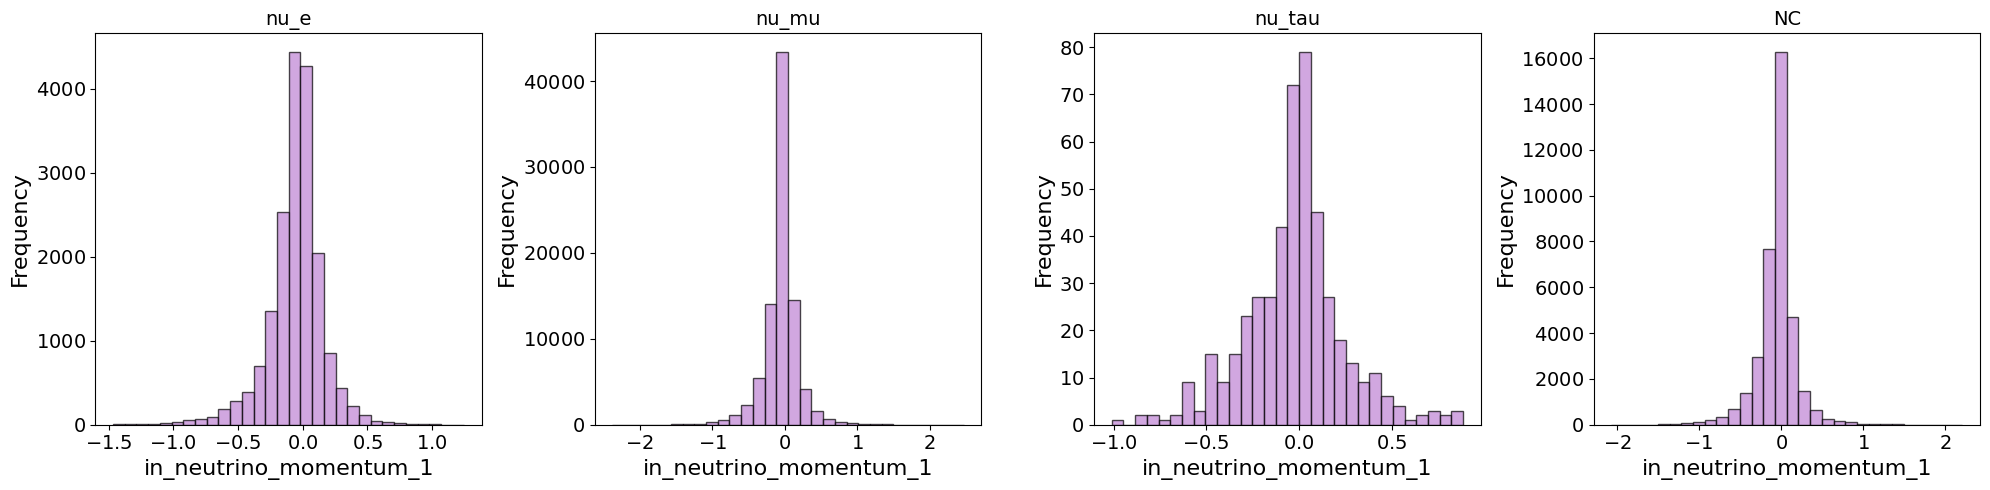

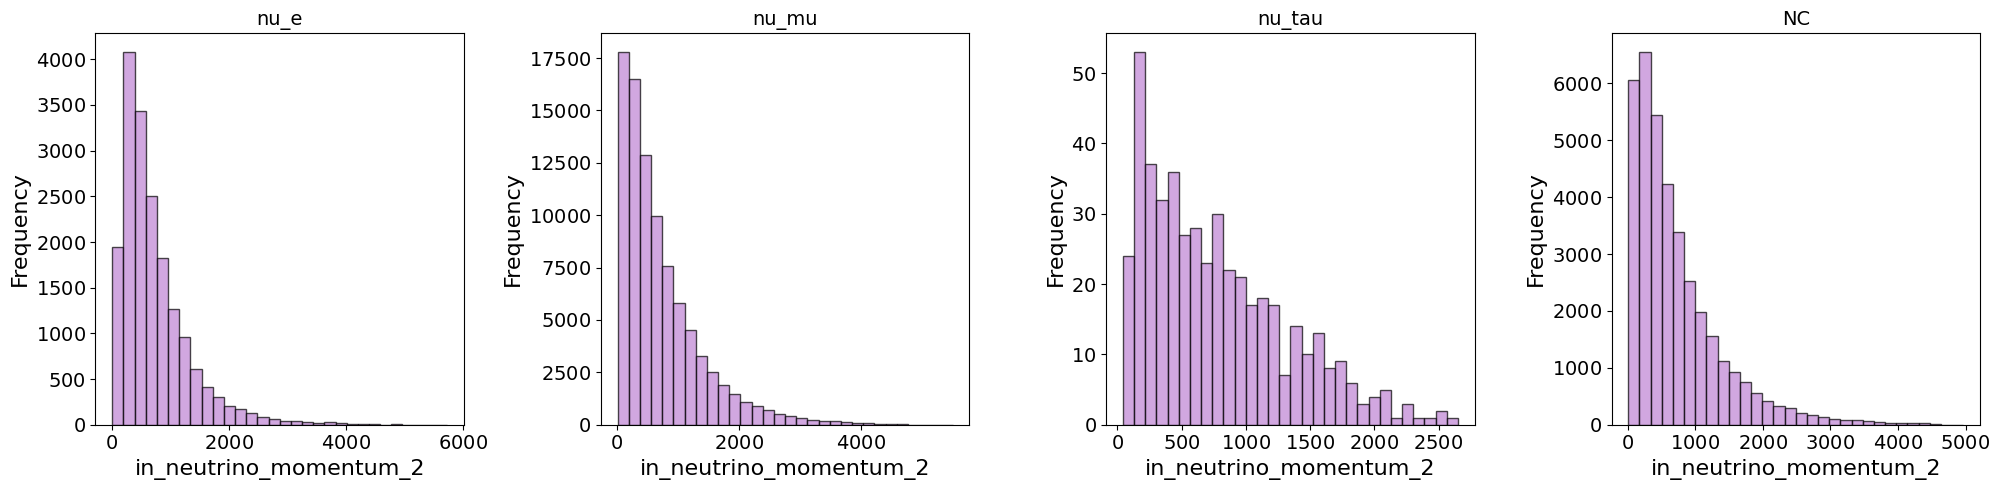

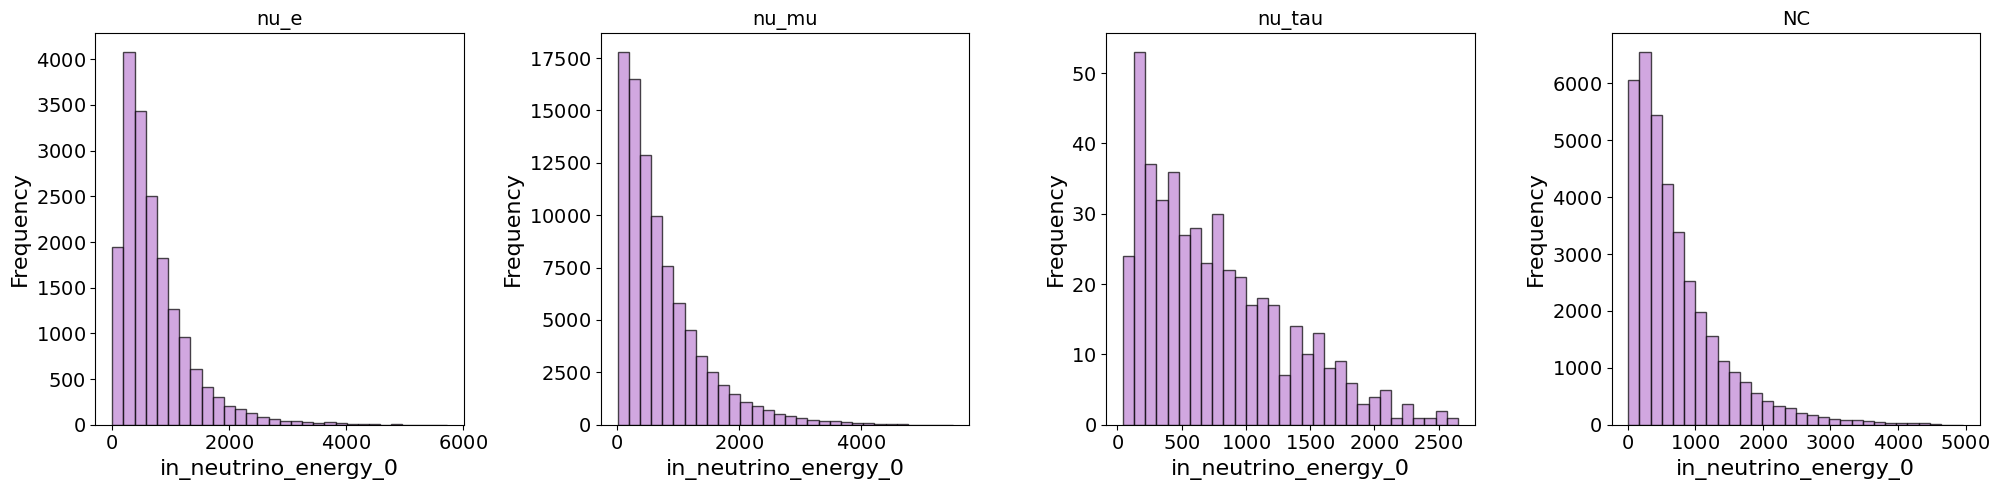

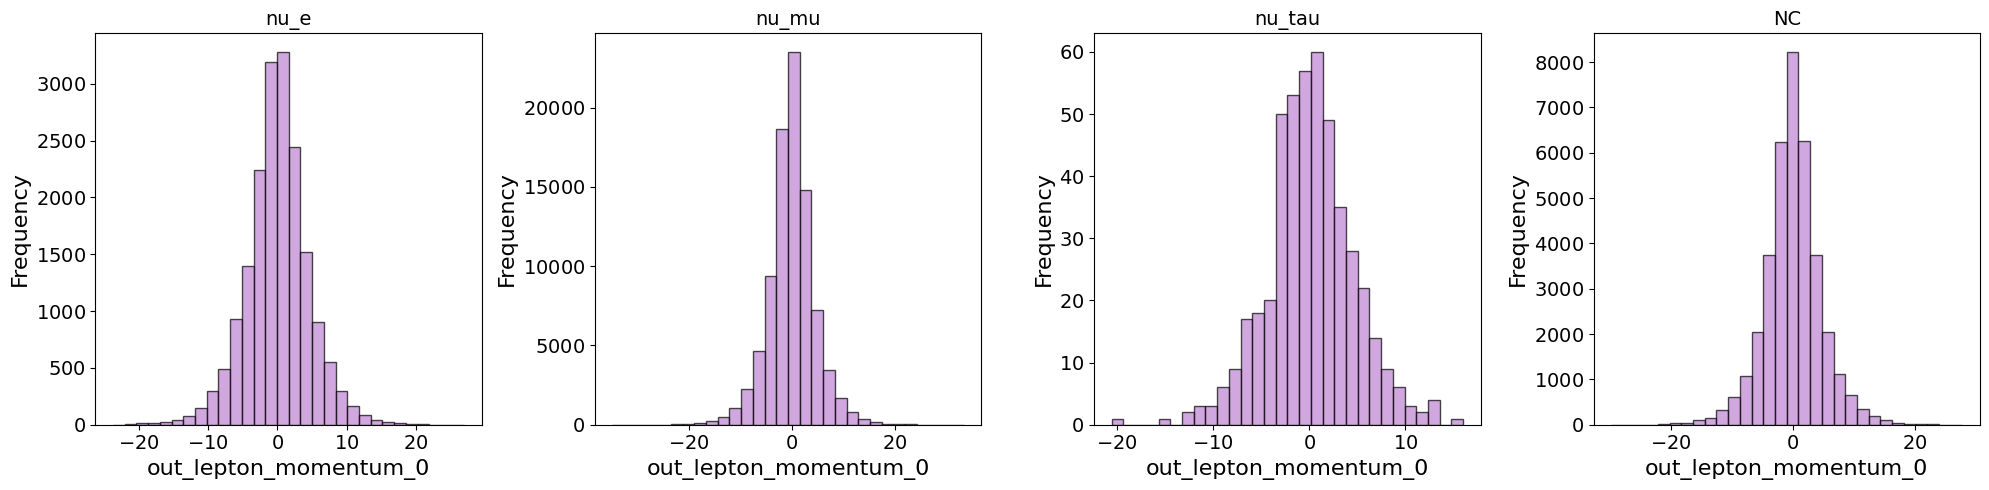

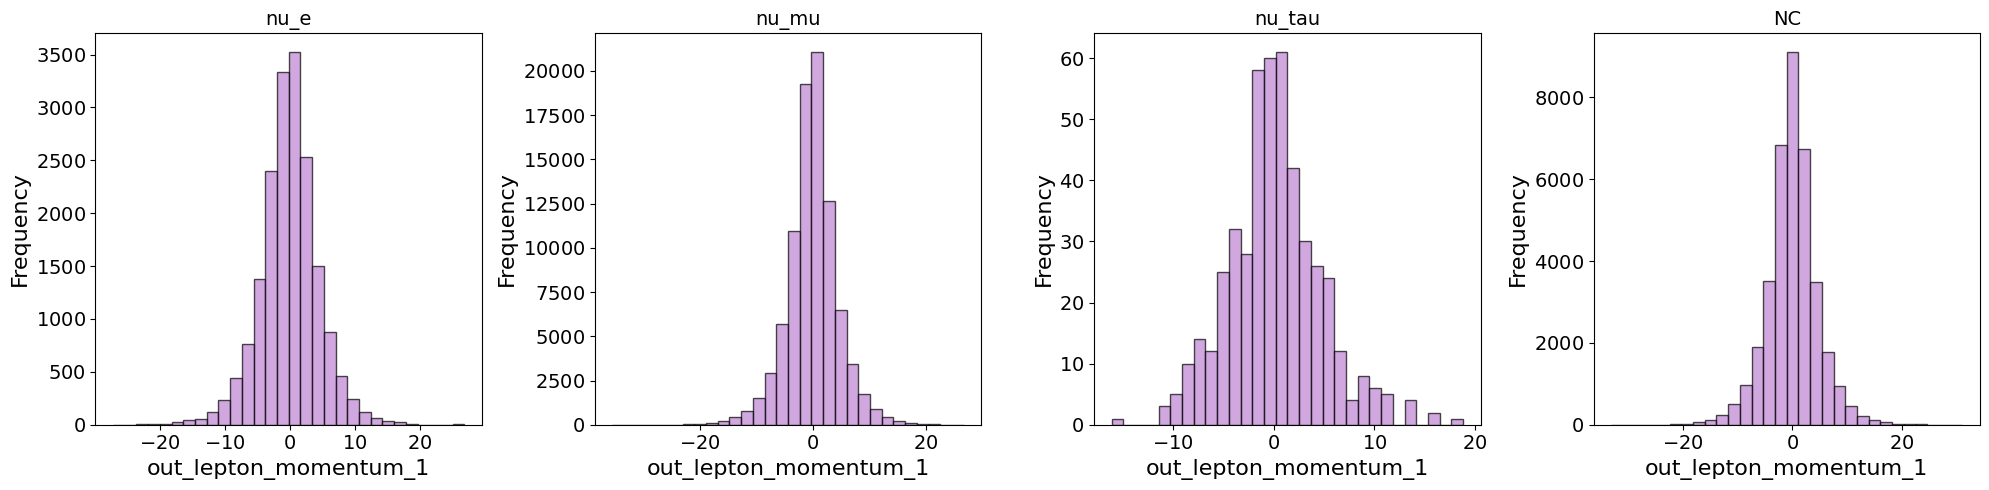

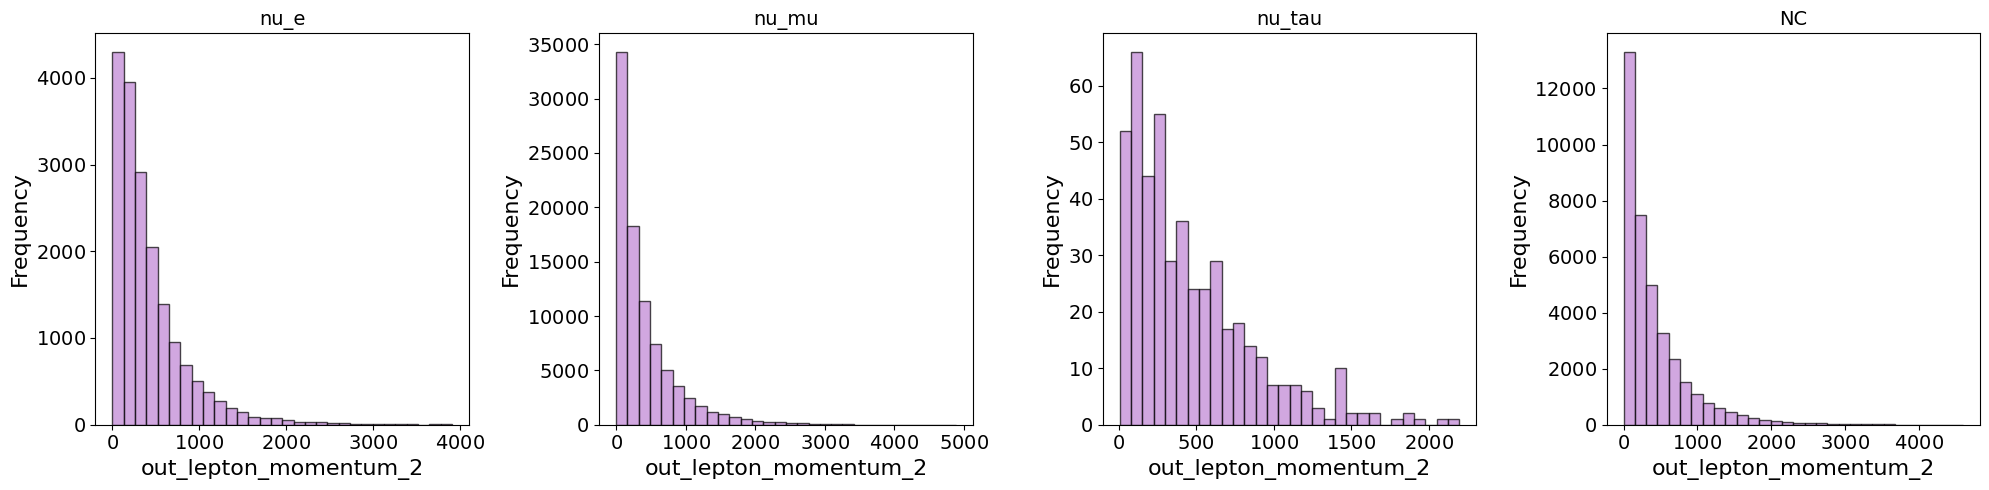

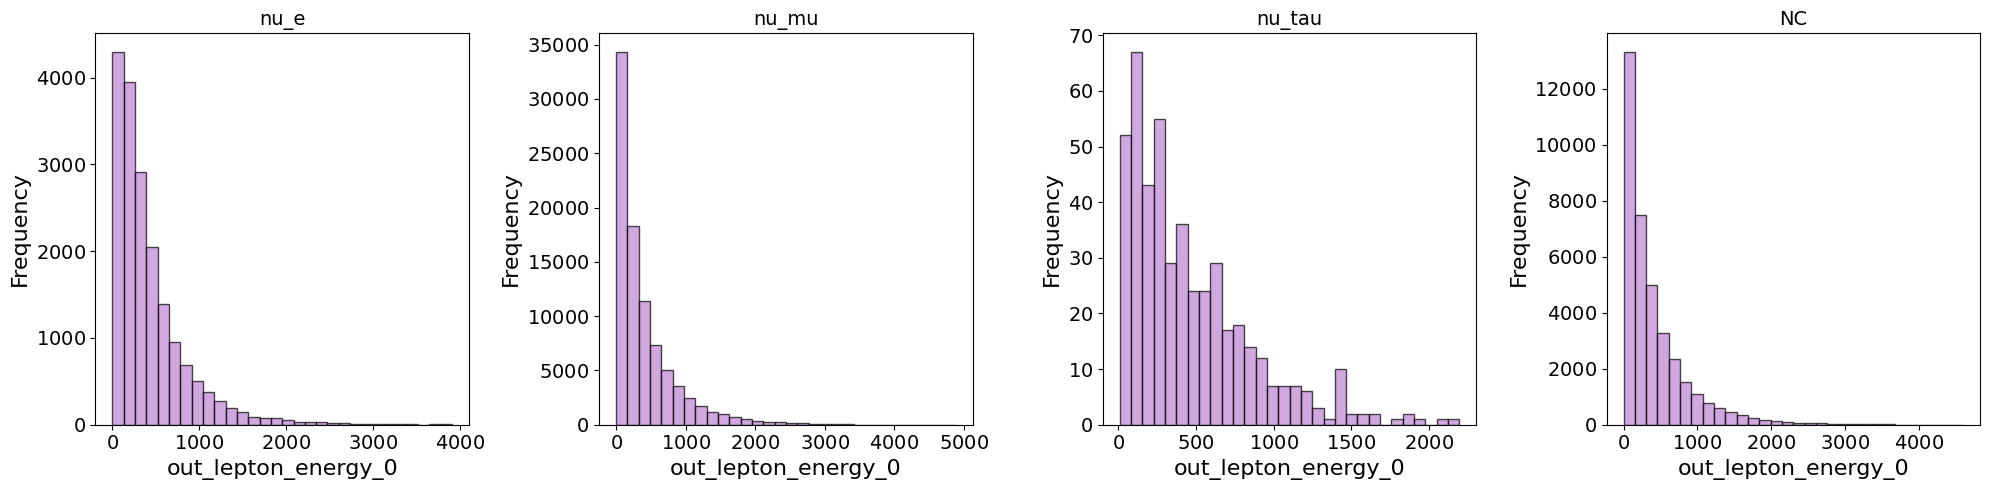

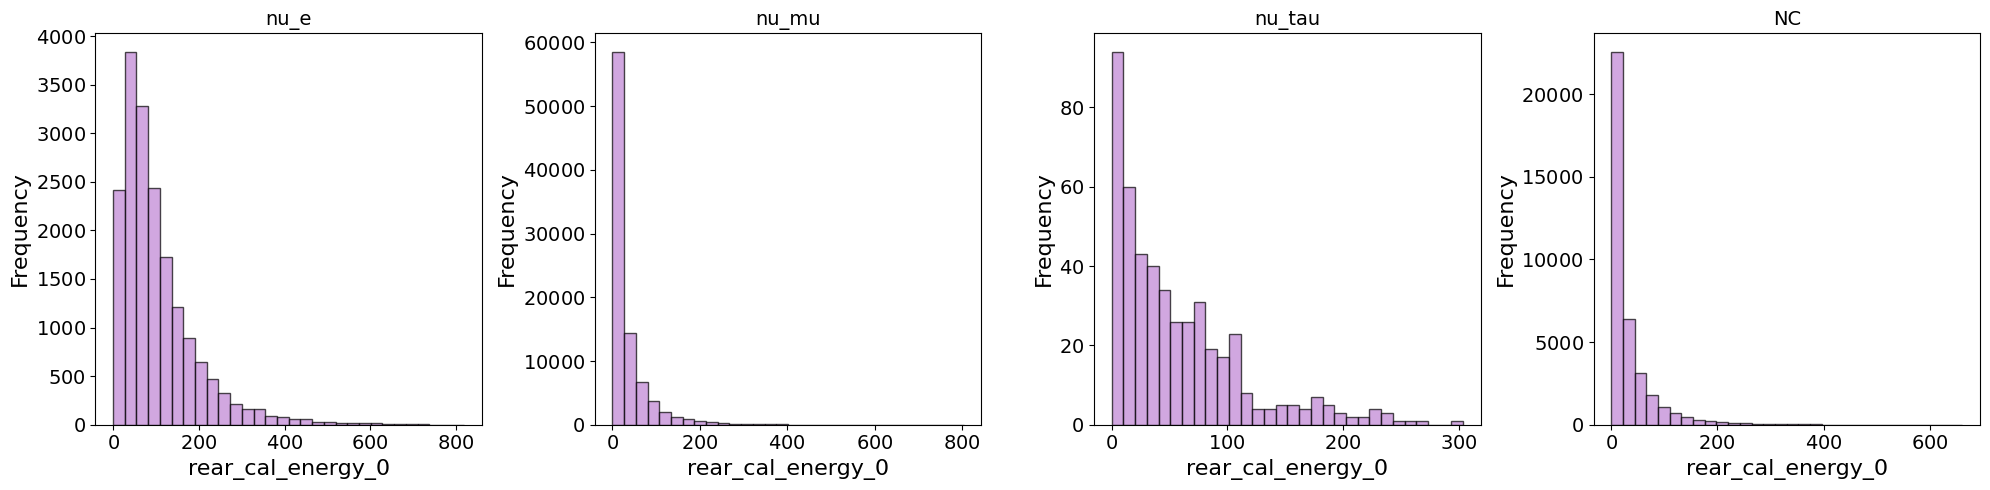

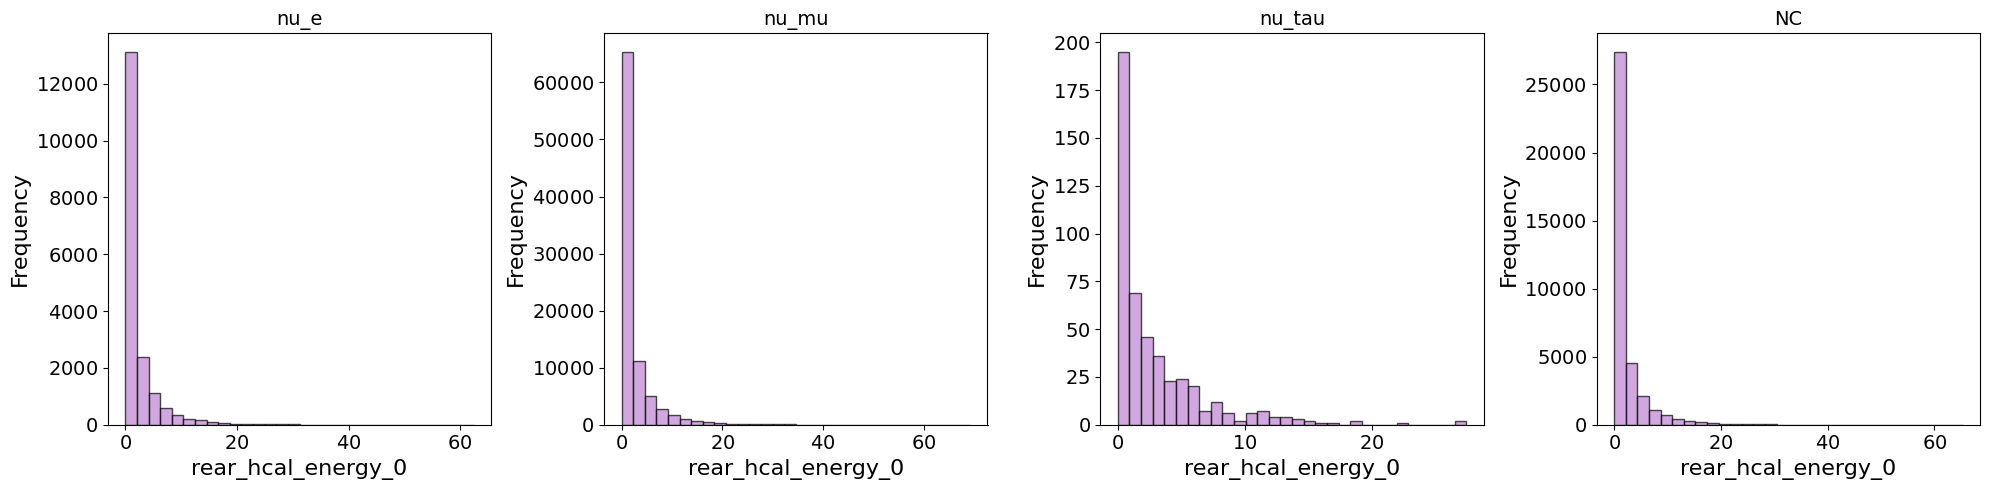

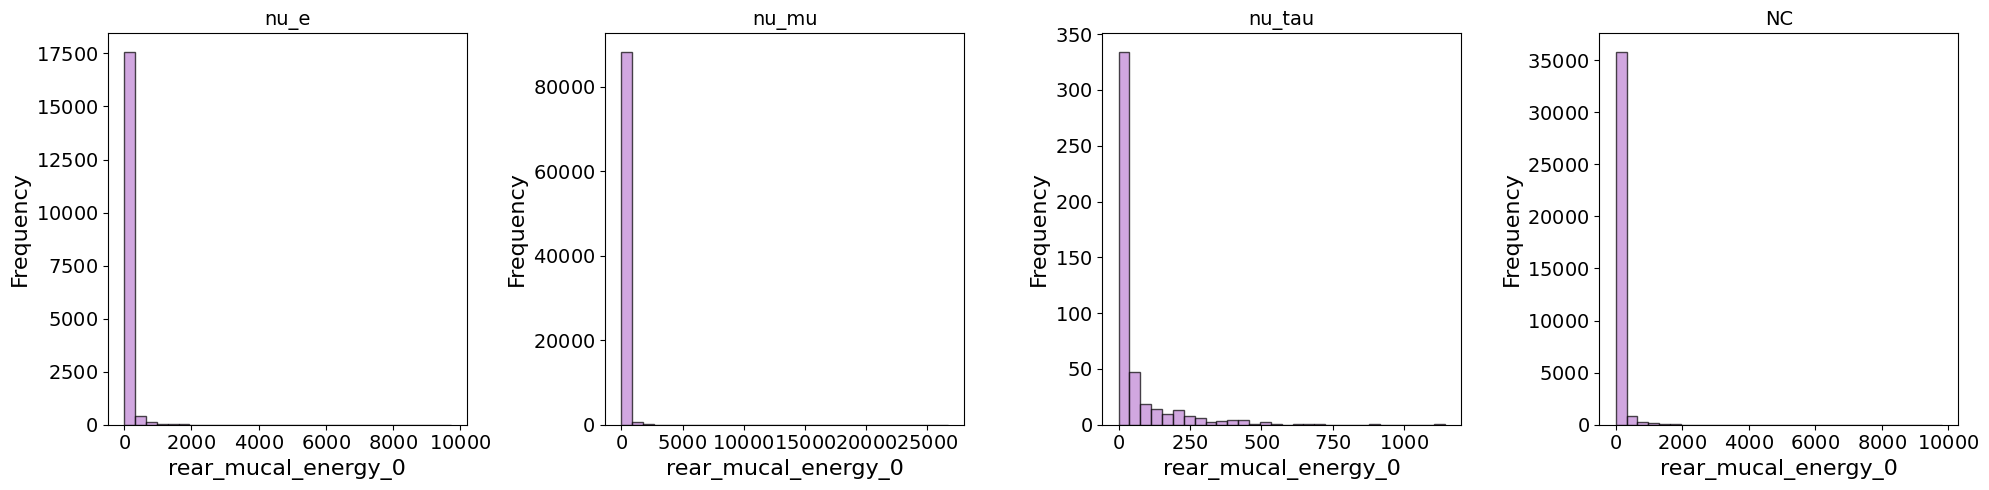

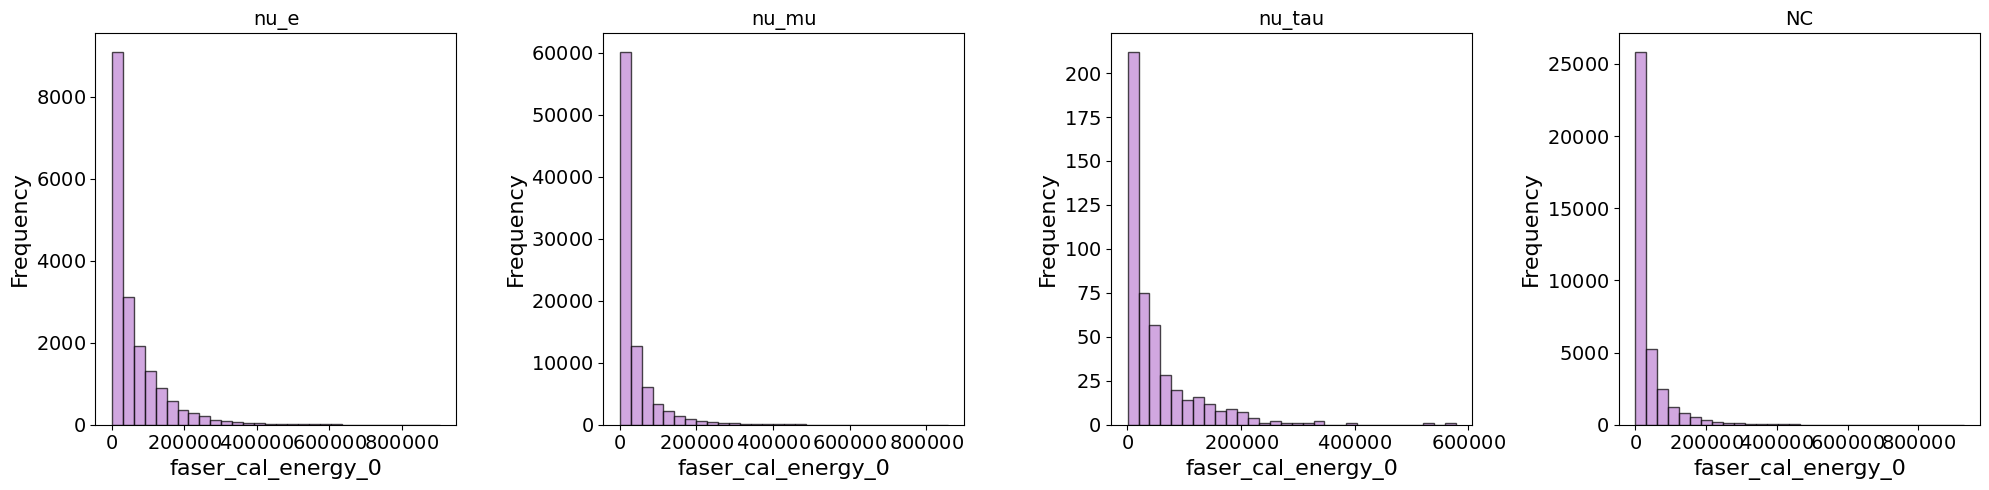

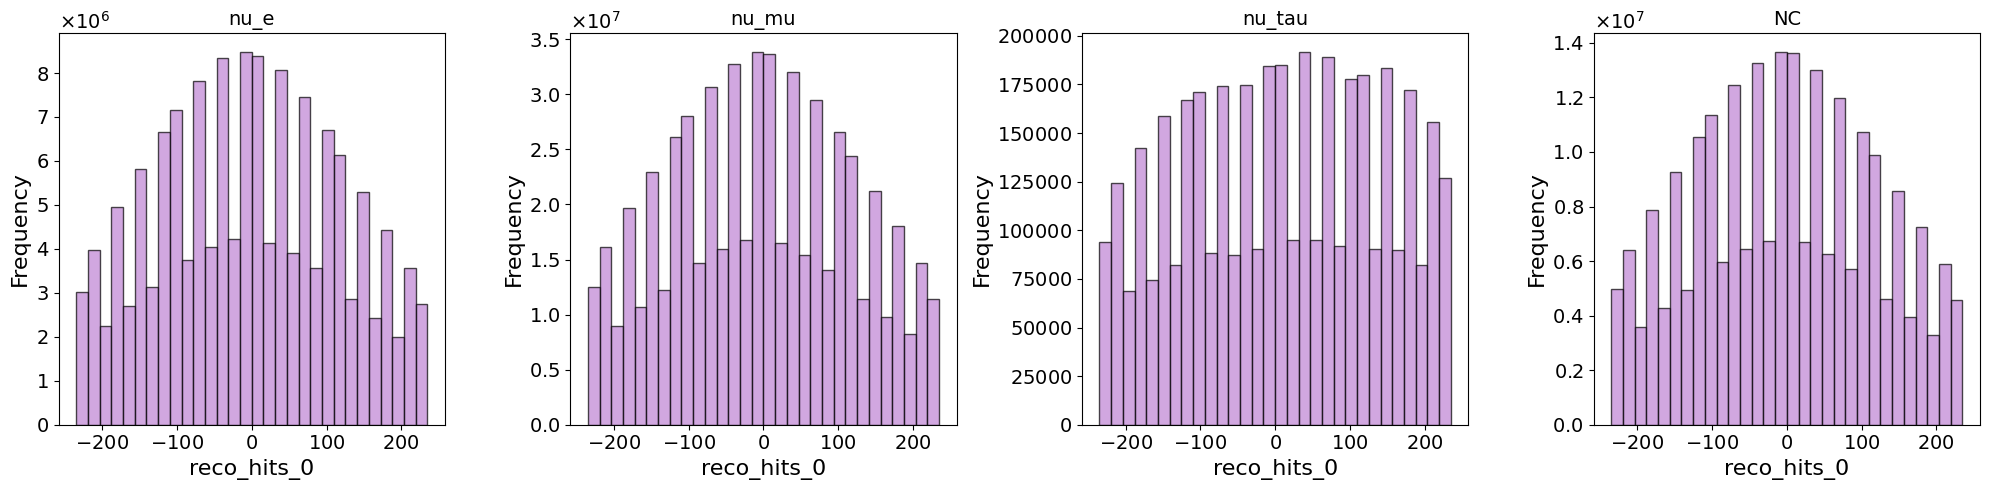

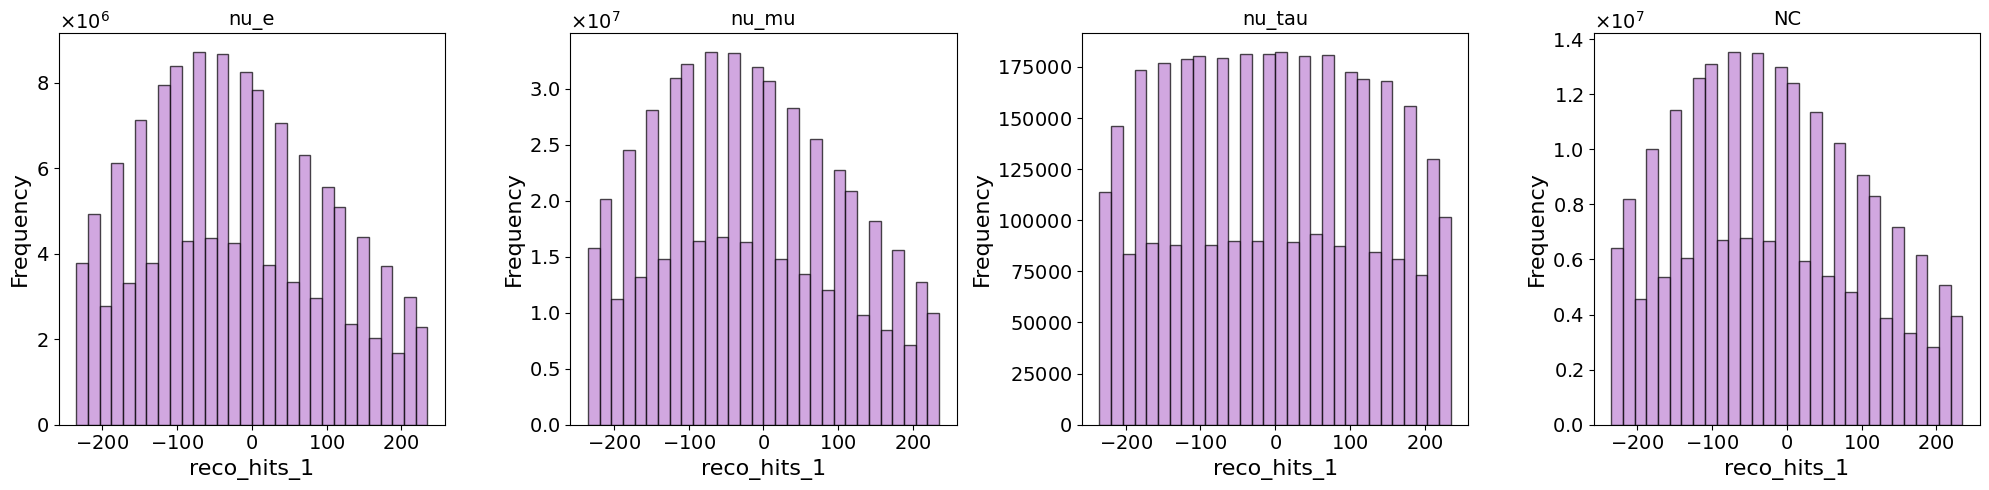

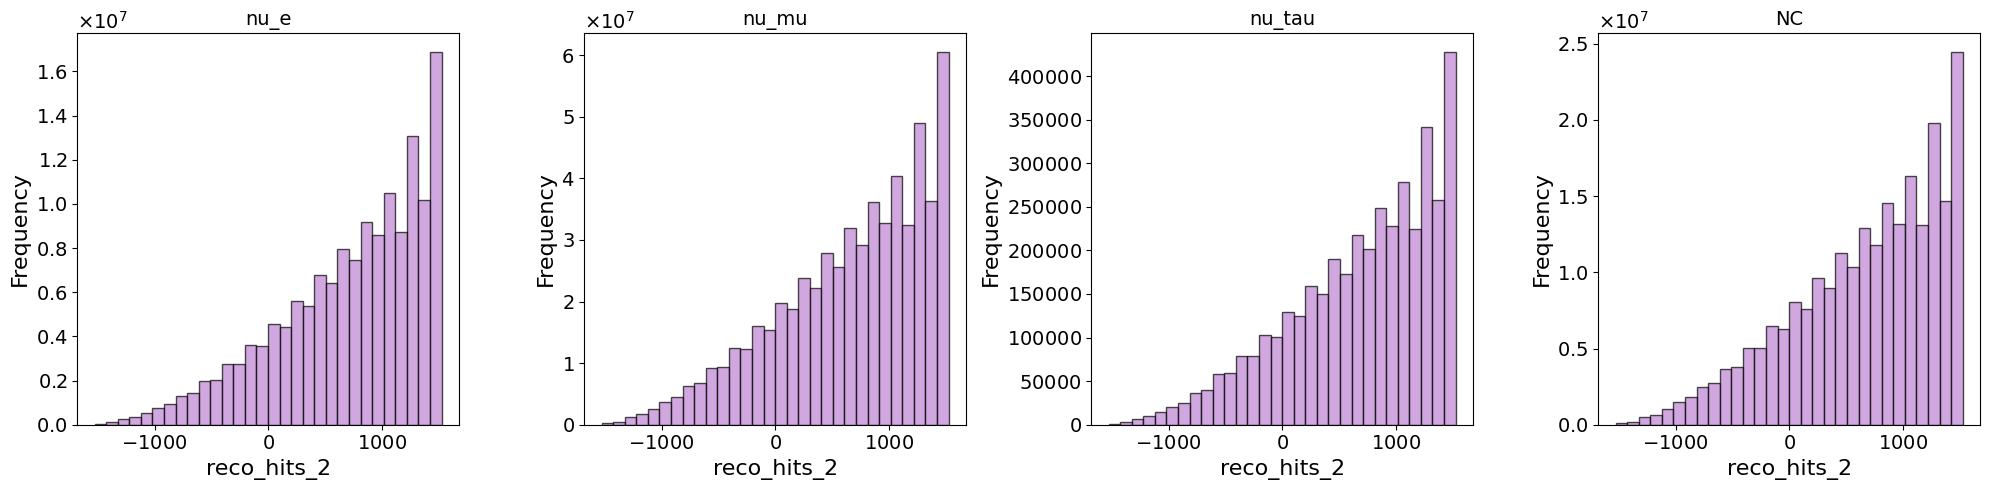

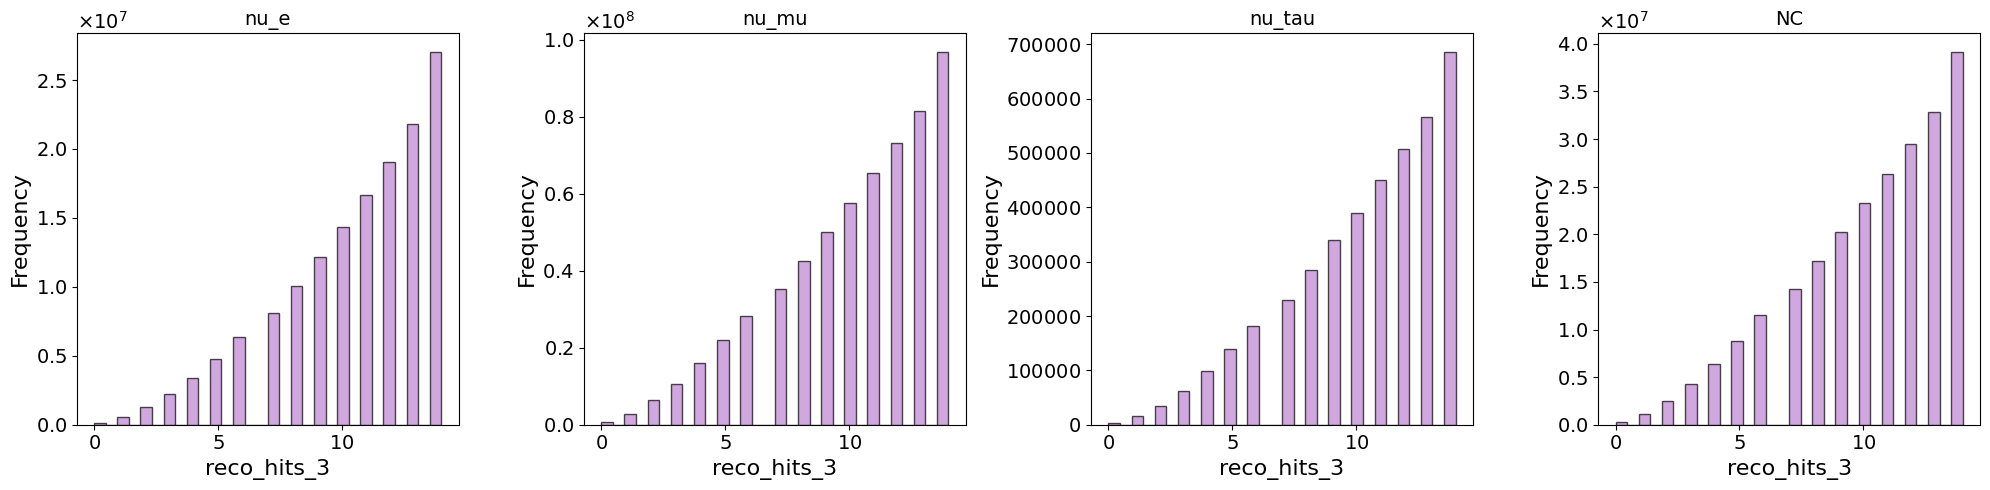

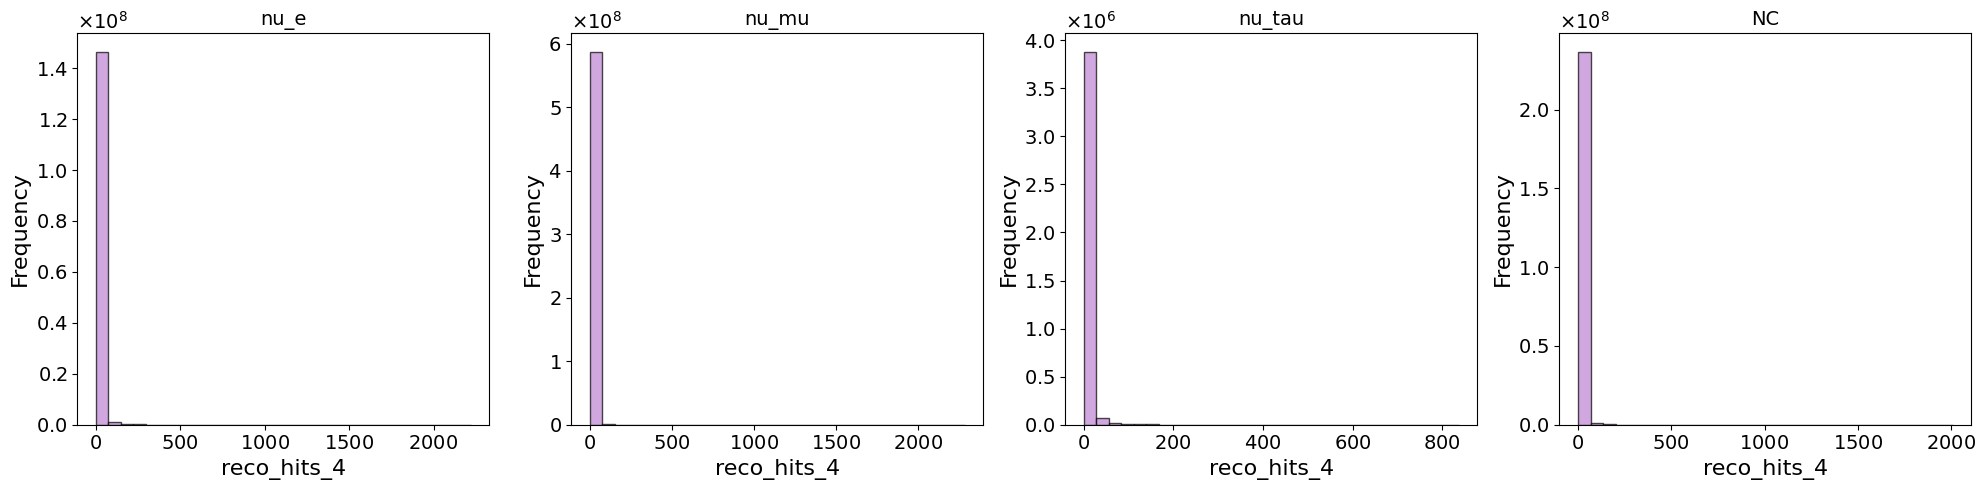

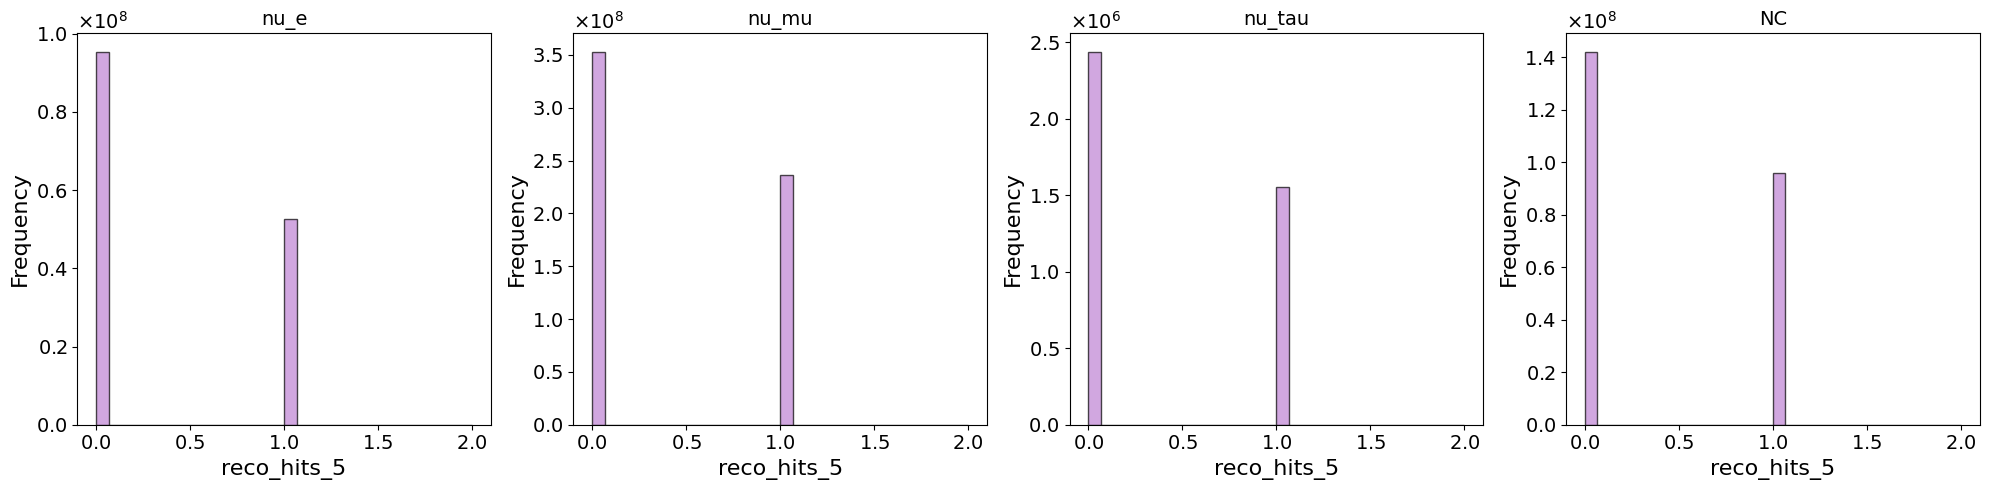

In [ ]:
# Example usage to plot 'e_vis'
for feat in variables_to_extract:
    plot_histograms(data_nu_e, data_nu_mu, data_nu_tau, data_nc, feat, bins=16, figsize=(20, 5))

In [ ]:
#plot just reco_hits, manually. First vstack all the hits
reco_hits_e = np.vstack(data_nu_e["reco_hits"])
reco_hits_mu = np.vstack(data_nu_mu["reco_hits"])
reco_hits_tau = np.vstack(data_nu_tau["reco_hits"])
rec_hits_nc = np.vstack(data_nc["reco_hits"])

Text(0, 0.5, 'Frequency')

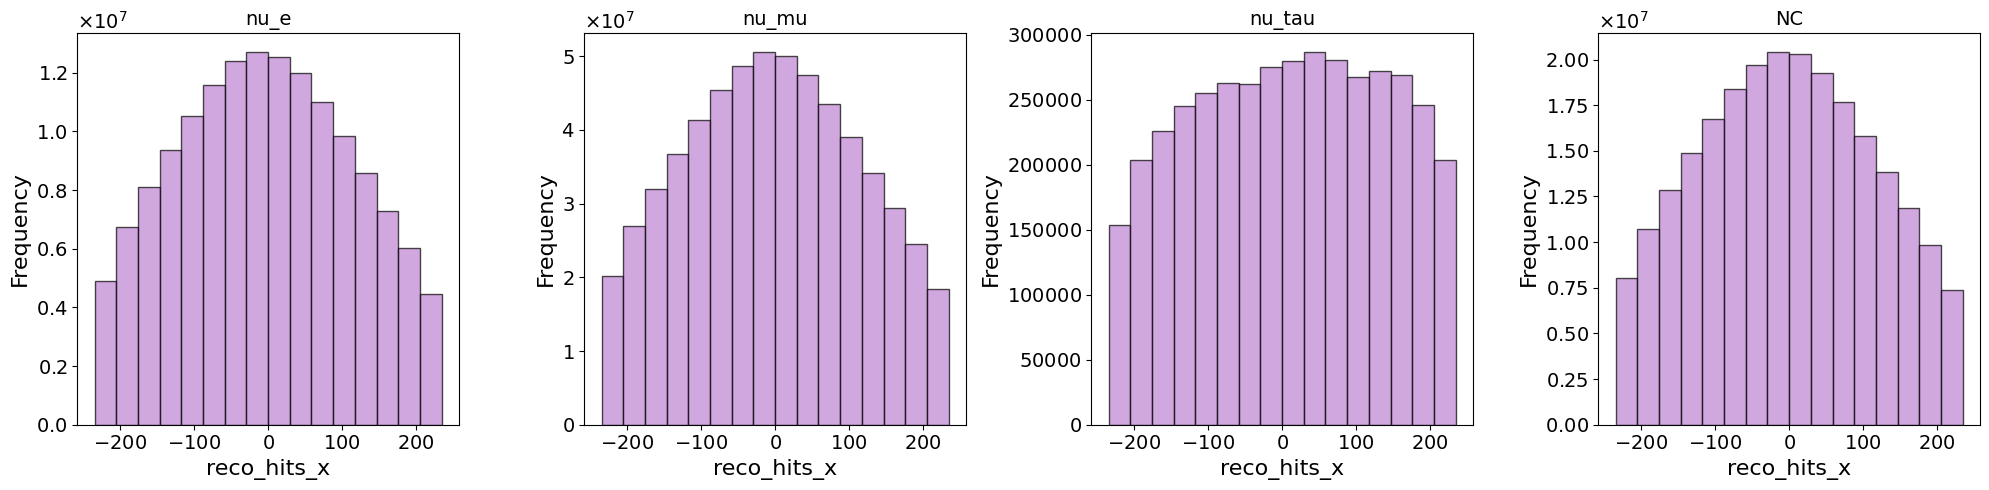

In [ ]:
#plot reco_hits y component in a 1,4 plot 
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

purple_color = (190/255, 130/255, 211/255)

# Plot the histograms in the respective subplots
axes[0].hist(reco_hits_e[:, 0], bins=16, alpha=0.7, color=purple_color, edgecolor='black')
axes[0].set_title(f'nu_e')
axes[0].set_xlabel(f'reco_hits_x')
axes[0].set_ylabel('Frequency')

axes[1].hist(reco_hits_mu[:, 0], bins=16, alpha=0.7, color=purple_color, edgecolor='black')
axes[1].set_title(f'nu_mu')
axes[1].set_xlabel(f'reco_hits_x')
axes[1].set_ylabel('Frequency')

axes[2].hist(reco_hits_tau[:, 0], bins=16, alpha=0.7, color=purple_color, edgecolor='black')
axes[2].set_title(f'nu_tau')
axes[2].set_xlabel(f'reco_hits_x')
axes[2].set_ylabel('Frequency')

axes[3].hist(rec_hits_nc[:, 0], bins=16, alpha=0.7, color=purple_color, edgecolor='black')
axes[3].set_title(f'NC')
axes[3].set_xlabel(f'reco_hits_x')
axes[3].set_ylabel('Frequency')